In [38]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 

In [3]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

In [4]:
data = pd.read_csv('20_newsgroup.csv', index_col = 0)
# Select only 5 classes
class_mask = data["target"].isin([7,9,13,18,19])
data = data[class_mask]
data.head()

,text,target,title,date
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,2022-04-04 11:36:57.825348
10,the blood of the lamb.\n\nThis will be a hard ...,19,talk.religion.misc,2022-04-04 11:36:57.825348
12,930418\n\nDo what thou wilt shall be the whole...,19,talk.religion.misc,2022-04-04 11:36:57.825348
40,\n\nNo. Zeno's paradox is resolved by showing...,19,talk.religion.misc,2022-04-04 11:36:57.825348
58,"\nDefinitely, J.R. ""Bob"" Dobbs, numero uno, to...",19,talk.religion.misc,2022-04-04 11:36:57.825348


In [5]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
df_train, df_test = train_test_split(data,test_size=0.2,shuffle=True)

In [6]:
! pip install seaborn

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

13    808
7     799
9     771
18    619
19    504
Name: target, dtype: int64


C:\Users\javij\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

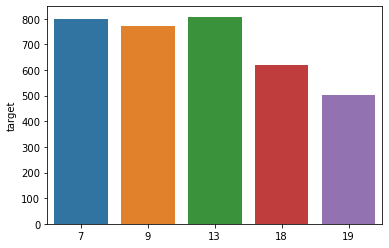

In [8]:
x=df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [9]:
df_train.isna().sum()

text      96
target     0
title      0
date       0
dtype: int64

In [10]:
# WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets

nan
nan


In [11]:
df_train = df_train.dropna()

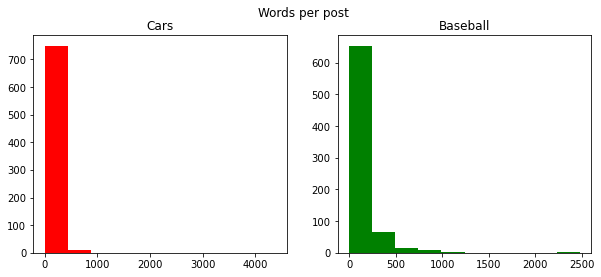

In [12]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==7]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Cars')
train_words=df_train[df_train['target']==9]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Baseball')
fig.suptitle('Words per post')
plt.show()

In [13]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==7]['char_count'].mean()) # Cars
print(df_train[df_train['target']==9]['char_count'].mean()) # Baseball

655.9084967320262
741.845126835781


In [14]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [15]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,text,target,title,date,word_count,char_count,clean_text
1145,To: smithmc@mentor.cc.purdue.edu (Lost Boy)\n\...,13,sci.med,2022-04-04 11:36:57.825348,85,464,smithmc mentor cc purdue edu lose boy lb know ...
17842,"Once, on Jeopardy, the category was ""Jewish Sp...",9,rec.sport.baseball,2022-04-04 11:36:57.825348,47,276,jeopardy category jewish sport hero believe an...
2522,\nPerhaps it's time to start rec.sport.basebal...,9,rec.sport.baseball,2022-04-04 11:36:57.825348,26,156,perhaps time start rec sport baseball graffiti...
16069,Pitchers are required to pitch (or feint or at...,9,rec.sport.baseball,2022-04-04 11:36:57.825348,66,410,pitcher require pitch feint attempt pick withi...
16952,THE WHITE HOUSE\n\n Office ...,18,talk.politics.misc,2022-04-04 11:36:57.825348,6795,44083,white house office press secretary immediate r...


In [16]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [42]:
#Tf-Idf vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [48]:
train_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df_train.clean_text)]

#df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']]
#model = Doc2Vec(df_train['clean_text_tok'],min_count=1) 
#model.train(df_train['clean_text_tok'],total_examples=model.corpus_count,epochs=model.epochs) 
#vocabulary = model.wv.key_to_index
#print(vocabulary)
#X_train_vectors_w2v = model.infer_vector(X_train)


#build the model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
#build vocab
model.build_vocab(train_docs)
#train model
model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)

#w2v = dict(zip(model.wv.index_to_key, model.wv.syn0)) 
#modelw = MeanEmbeddingVectorizer(w2v)
# converting text to numerical data using Word2Vec
#X_train_vectors_w2v = modelw.transform(X_train_tok)
#X_val_vectors_w2v = modelw.transform(X_test_tok)

In [55]:
# Obtain vectors via doc2vec

#obtain vectors
X_train_w2v = [model.infer_vector((df_train['clean_text']))]
X_train_w2v



[array([-0.25874043,  1.1185209 ,  0.3120277 , -0.35389134, -1.5458192 ,
        -1.68722   , -0.68962353, -2.906109  , -0.5213135 ,  0.06566475,
        -0.8651967 ,  1.5320686 , -0.31730762, -0.59954286, -0.6015005 ,
        -0.80938417, -0.8053903 ,  0.3246122 , -0.9974956 , -0.13016574,
         1.0021578 ,  0.43067658, -1.8008988 , -3.5852244 ,  1.235158  ,
         1.4656229 ,  1.1663276 ,  1.3954955 ,  1.3334296 ,  0.51781756,
        -0.84291404,  1.3346603 ,  0.5383233 , -0.48546964, -0.84437084,
        -0.94789004, -1.2345388 , -0.15339524,  0.8073576 , -1.1992388 ,
         1.1331251 ,  0.06544114,  0.18559176, -0.7354784 ,  1.0213753 ,
         2.5004113 , -2.260173  ,  0.6453216 ,  3.6350408 ,  2.0464845 ,
         0.5209505 , -1.2768697 , -1.5271027 , -0.41000056, -1.3828931 ,
        -2.4341857 , -0.07375979,  0.68664694,  0.97514474, -0.23778099,
        -0.8964627 , -0.43850324, -2.6148975 , -2.1694968 ], dtype=float32)]

In [18]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, balanced_accuracy_score

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Logistic Regression(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Logistic Regression(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Logistic Regression(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           7       0.84      0.91      0.87       149
           9       0.93      0.91      0.92       151
          13       0.85      0.94      0.89       145
          18       0.84      0.78      0.81       138
          19       0.85      0.73      0.79        98

    accuracy                           0.86       681
   macro avg       0.86      0.85      0.86       681
weighted avg       0.86      0.86      0.86       681

Confusion Matrix: [[135   5   5   4   0]
 [  4 138   5   3   1]
 [  3   2 136   2   2]
 [ 10   2   9 107  10]
 [  8   2   5  11  72]]
Test Accuracy of Logistic Regression(tf-idf) is 0.8634361233480177 

Test Balanced Accuracy of Logistic Regression(tf-idf) is 0.8535869568197894 

Test F1-score weighted of Logistic Regression(tf-idf) is 0.8619411361225265 



In [19]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Naive Bayes(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Naive Bayes(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           7       0.93      0.94      0.94       149
           9       0.91      0.93      0.92       151
          13       0.71      0.96      0.82       145
          18       0.85      0.78      0.81       138
          19       0.96      0.54      0.69        98

    accuracy                           0.85       681
   macro avg       0.87      0.83      0.83       681
weighted avg       0.87      0.85      0.85       681

Confusion Matrix: [[140   1   6   2   0]
 [  0 140  11   0   0]
 [  3   2 139   0   1]
 [  5   3  22 107   1]
 [  2   8  18  17  53]]
Test Accuracy of Naive Bayes(tf-idf) is 0.8502202643171806 

Test Balanced Accuracy of Naive Bayes(tf-idf) is 0.8283097936686801 

Test F1-score weighted of Naive Bayes(tf-idf) is 0.8459984262704484 

